<a href="https://colab.research.google.com/github/BigChungus71/weather-prediction/blob/main/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded: 9131 records from 2000-01-02 00:00:00 to 2024-12-31 00:00:00

Training Random Forest models...
✓ Maximum temperature model trained
✓ Minimum temperature model trained

MODEL PERFORMANCE METRICS

Maximum Temperature Model:
  Mean Absolute Error: 0.42°C
  Root Mean Squared Error: 0.55°C
  R² Score: 0.9652

Minimum Temperature Model:
  Mean Absolute Error: 0.29°C
  Root Mean Squared Error: 0.40°C
  R² Score: 0.9733

GENERATING VISUALIZATIONS...


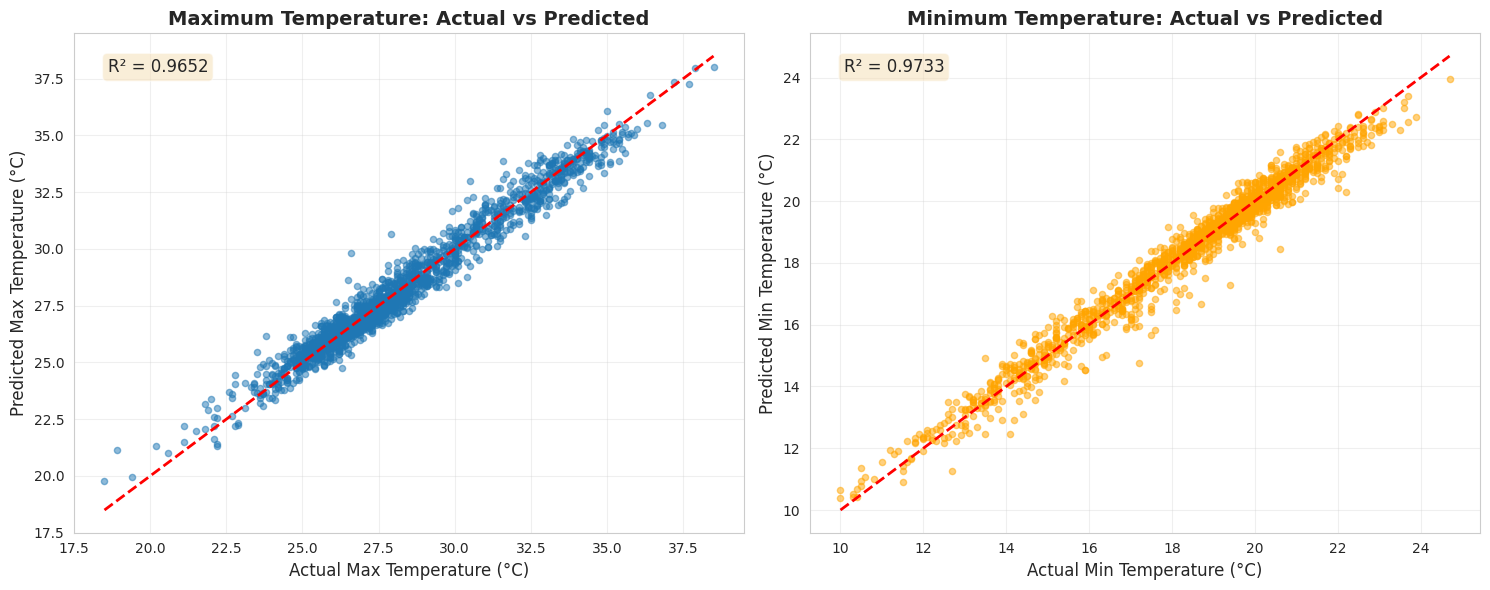

✓ Visualization 1: Model Performance (Actual vs Predicted)


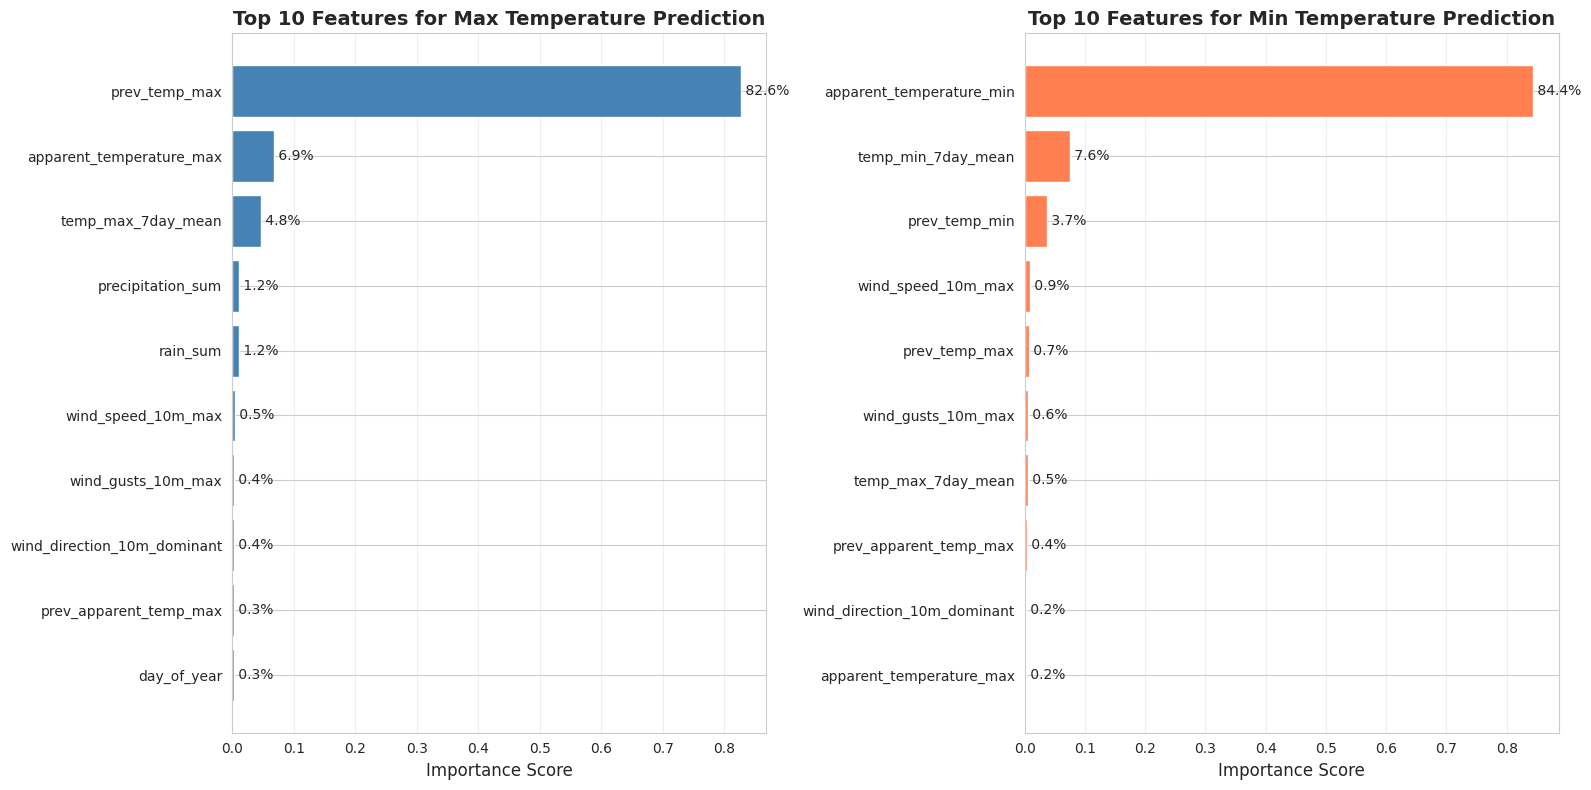

✓ Visualization 2: Feature Importance Analysis


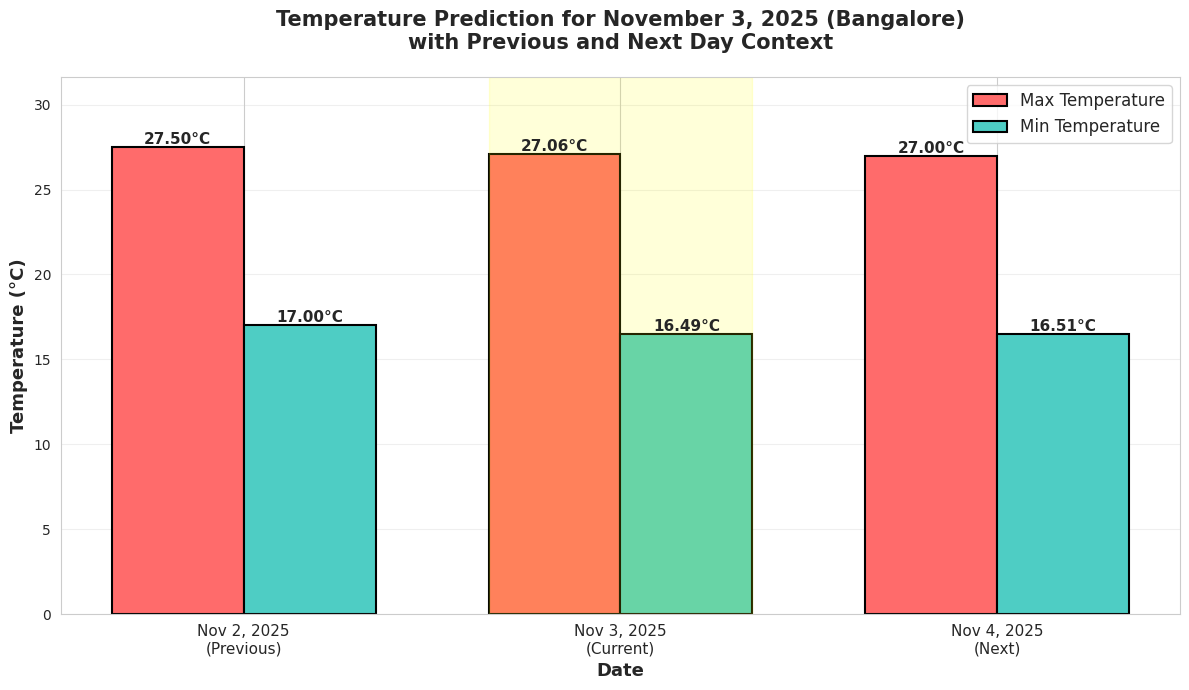

✓ Visualization 3: Future Temperature Predictions (Nov 3, 2025)


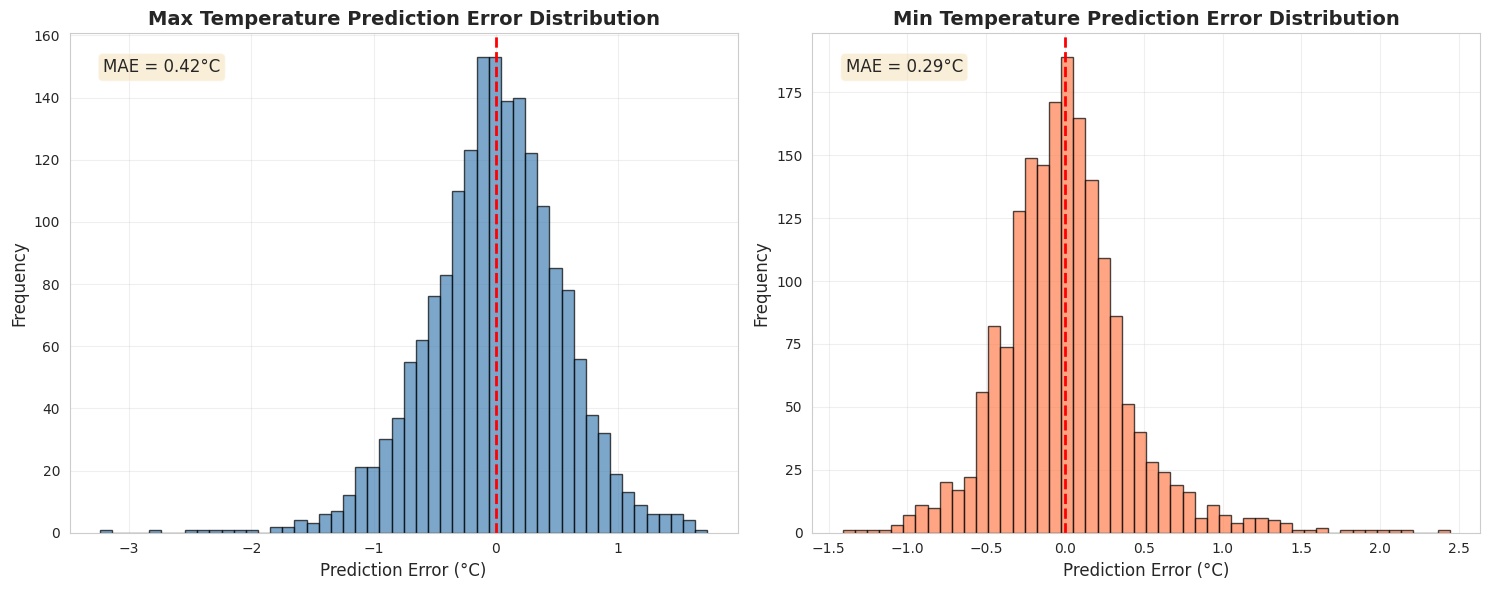

✓ Visualization 4: Prediction Error Distribution

TEMPERATURE PREDICTIONS FOR NOVEMBER 2025

2025-11-03 (Monday):
  Predicted Max: 27.06°C
  Predicted Min: 16.49°C
  Previous Day: Max = 27.50°C, Min = 17.00°C
  Next Day: Max = 27.00°C, Min = 16.51°C


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load and preprocess the dataset
df = pd.read_csv('india_2000_2024_daily_weather.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df = df.sort_values(['city', 'date']).reset_index(drop=True)

# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek

# Create lagged features
df['prev_temp_max'] = df.groupby('city')['temperature_2m_max'].shift(1)
df['prev_temp_min'] = df.groupby('city')['temperature_2m_min'].shift(1)
df['prev_apparent_temp_max'] = df.groupby('city')['apparent_temperature_max'].shift(1)
df['prev_apparent_temp_min'] = df.groupby('city')['apparent_temperature_min'].shift(1)

# Create rolling mean features
df['temp_max_7day_mean'] = df.groupby('city')['temperature_2m_max'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
df['temp_min_7day_mean'] = df.groupby('city')['temperature_2m_min'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

df_clean = df.dropna().reset_index(drop=True)

print(f"Dataset loaded: {df_clean.shape[0]} records from {df_clean['date'].min()} to {df_clean['date'].max()}")

# Prepare features and targets
feature_cols = [
    'year', 'month', 'day', 'day_of_year', 'day_of_week',
    'apparent_temperature_max', 'apparent_temperature_min',
    'precipitation_sum', 'rain_sum', 'weather_code',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'prev_temp_max', 'prev_temp_min', 'prev_apparent_temp_max', 'prev_apparent_temp_min',
    'temp_max_7day_mean', 'temp_min_7day_mean'
]

X = df_clean[feature_cols]
y_max = df_clean['temperature_2m_max']
y_min = df_clean['temperature_2m_min']

# Split data
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
_, _, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)

# Train models
print("\nTraining Random Forest models...")
rf_max = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20, min_samples_split=5, n_jobs=-1)
rf_max.fit(X_train, y_max_train)
print("✓ Maximum temperature model trained")

rf_min = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20, min_samples_split=5, n_jobs=-1)
rf_min.fit(X_train, y_min_train)
print("✓ Minimum temperature model trained")

# Get predictions
y_max_pred = rf_max.predict(X_test)
y_min_pred = rf_min.predict(X_test)

# Print model performance
print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"\nMaximum Temperature Model:")
print(f"  Mean Absolute Error: {mean_absolute_error(y_max_test, y_max_pred):.2f}°C")
print(f"  Root Mean Squared Error: {np.sqrt(mean_squared_error(y_max_test, y_max_pred)):.2f}°C")
print(f"  R² Score: {r2_score(y_max_test, y_max_pred):.4f}")

print(f"\nMinimum Temperature Model:")
print(f"  Mean Absolute Error: {mean_absolute_error(y_min_test, y_min_pred):.2f}°C")
print(f"  Root Mean Squared Error: {np.sqrt(mean_squared_error(y_min_test, y_min_pred)):.2f}°C")
print(f"  R² Score: {r2_score(y_min_test, y_min_pred):.4f}")

# ============================================================================
# VISUALIZATION 1: Model Performance - Actual vs Predicted
# ============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS...")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Max Temperature
axes[0].scatter(y_max_test, y_max_pred, alpha=0.5, s=20)
axes[0].plot([y_max_test.min(), y_max_test.max()],
             [y_max_test.min(), y_max_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Max Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Max Temperature (°C)', fontsize=12)
axes[0].set_title('Maximum Temperature: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
r2_max = r2_score(y_max_test, y_max_pred)
axes[0].text(0.05, 0.95, f'R² = {r2_max:.4f}', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Min Temperature
axes[1].scatter(y_min_test, y_min_pred, alpha=0.5, s=20, color='orange')
axes[1].plot([y_min_test.min(), y_min_test.max()],
             [y_min_test.min(), y_min_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Min Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Min Temperature (°C)', fontsize=12)
axes[1].set_title('Minimum Temperature: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
r2_min = r2_score(y_min_test, y_min_pred)
axes[1].text(0.05, 0.95, f'R² = {r2_min:.4f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('model_performance_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization 1: Model Performance (Actual vs Predicted)")

# ============================================================================
# VISUALIZATION 2: Feature Importance
# ============================================================================
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Max_Temp': rf_max.feature_importances_,
    'Min_Temp': rf_min.feature_importances_
}).sort_values('Max_Temp', ascending=False)

# Top 10 features
top_10 = feature_importance.head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Max Temperature Feature Importance
axes[0].barh(range(len(top_10)), top_10['Max_Temp'], color='steelblue')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['Feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Top 10 Features for Max Temperature Prediction', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, v in enumerate(top_10['Max_Temp']):
    axes[0].text(v, i, f' {v*100:.1f}%', va='center', fontsize=10)

# Min Temperature Feature Importance
top_10_min = feature_importance.sort_values('Min_Temp', ascending=False).head(10)
axes[1].barh(range(len(top_10_min)), top_10_min['Min_Temp'], color='coral')
axes[1].set_yticks(range(len(top_10_min)))
axes[1].set_yticklabels(top_10_min['Feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('Top 10 Features for Min Temperature Prediction', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, v in enumerate(top_10_min['Min_Temp']):
    axes[1].text(v, i, f' {v*100:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization 2: Feature Importance Analysis")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)

# ============================================================================
# PREDICT FOR NOVEMBER 3, 2025
# ============================================================================
def predict_future_temperatures(start_date, num_days=1):
    last_date = df_clean['date'].max()
    last_data = df_clean[df_clean['date'] == last_date].iloc[0]

    predictions = []
    current_data = last_data.copy()
    start_dt = pd.to_datetime(start_date)

    # Get previous day (Dec 31, 2024)
    prev_data = df_clean[df_clean['date'] == last_date].iloc[0]

    for i in range(num_days + 1):  # +1 to get next day prediction too
        predict_date = start_dt + timedelta(days=i)

        features = {
            'year': predict_date.year,
            'month': predict_date.month,
            'day': predict_date.day,
            'day_of_year': predict_date.dayofyear,
            'day_of_week': predict_date.dayofweek,
            'apparent_temperature_max': current_data['apparent_temperature_max'],
            'apparent_temperature_min': current_data['apparent_temperature_min'],
            'precipitation_sum': current_data['precipitation_sum'],
            'rain_sum': current_data['rain_sum'],
            'weather_code': current_data['weather_code'],
            'wind_speed_10m_max': current_data['wind_speed_10m_max'],
            'wind_gusts_10m_max': current_data['wind_gusts_10m_max'],
            'wind_direction_10m_dominant': current_data['wind_direction_10m_dominant'],
            'prev_temp_max': current_data['temperature_2m_max'],
            'prev_temp_min': current_data['temperature_2m_min'],
            'prev_apparent_temp_max': current_data['apparent_temperature_max'],
            'prev_apparent_temp_min': current_data['apparent_temperature_min'],
            'temp_max_7day_mean': current_data['temp_max_7day_mean'],
            'temp_min_7day_mean': current_data['temp_min_7day_mean']
        }

        X_pred = pd.DataFrame([features])
        pred_max = rf_max.predict(X_pred)[0]
        pred_min = rf_min.predict(X_pred)[0]

        predictions.append({
            'date': predict_date,
            'max_temp': pred_max,
            'min_temp': pred_min
        })

        current_data['temperature_2m_max'] = pred_max
        current_data['temperature_2m_min'] = pred_min
        current_data['apparent_temperature_max'] = pred_max + 0.5
        current_data['apparent_temperature_min'] = pred_min - 0.5
        current_data['temp_max_7day_mean'] = (current_data['temp_max_7day_mean'] * 6 + pred_max) / 7
        current_data['temp_min_7day_mean'] = (current_data['temp_min_7day_mean'] * 6 + pred_min) / 7

    return pd.DataFrame(predictions), prev_data

# Generate predictions for Nov 3, 2025
future_predictions, prev_day_data = predict_future_temperatures('2025-11-03', num_days=1)

# ============================================================================
# VISUALIZATION 3: Future Temperature Predictions (Nov 3, 2025)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data with previous day
dates = ['Nov 2, 2025\n(Previous)', 'Nov 3, 2025\n(Current)', 'Nov 4, 2025\n(Next)']
max_temps = [prev_day_data['temperature_2m_max'],
             future_predictions.iloc[0]['max_temp'],
             future_predictions.iloc[1]['max_temp']]
min_temps = [prev_day_data['temperature_2m_min'],
             future_predictions.iloc[0]['min_temp'],
             future_predictions.iloc[1]['min_temp']]

x_pos = [0, 1, 2]

# Plot bars
width = 0.35
bars1 = ax.bar([x - width/2 for x in x_pos], max_temps, width, label='Max Temperature',
               color='#FF6B6B', edgecolor='black', linewidth=1.5)
bars2 = ax.bar([x + width/2 for x in x_pos], min_temps, width, label='Min Temperature',
               color='#4ECDC4', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}°C',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}°C',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=13, fontweight='bold')
ax.set_title('Temperature Prediction for November 3, 2025 (Bangalore)\nwith Previous and Next Day Context',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(max_temps) * 1.15)

# Highlight current day
ax.axvspan(0.65, 1.35, alpha=0.15, color='yellow')

plt.tight_layout()
plt.savefig('future_temperature_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization 3: Future Temperature Predictions (Nov 3, 2025)")

# ============================================================================
# VISUALIZATION 4: Prediction Error Distribution
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Max Temperature Errors
errors_max = y_max_test - y_max_pred
axes[0].hist(errors_max, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error (°C)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Max Temperature Prediction Error Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
mae_max = mean_absolute_error(y_max_test, y_max_pred)
axes[0].text(0.05, 0.95, f'MAE = {mae_max:.2f}°C', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Min Temperature Errors
errors_min = y_min_test - y_min_pred
axes[1].hist(errors_min, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Min Temperature Prediction Error Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
mae_min = mean_absolute_error(y_min_test, y_min_pred)
axes[1].text(0.05, 0.95, f'MAE = {mae_min:.2f}°C', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('prediction_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization 4: Prediction Error Distribution")

# ============================================================================
# Print Prediction for November 3, 2025
# ============================================================================
print("\n" + "="*70)
print("TEMPERATURE PREDICTIONS FOR NOVEMBER 2025")
print("="*70)

# Get the specific predictions
current_day = future_predictions.iloc[0]
next_day = future_predictions.iloc[1]

print(f"\n2025-11-03 (Monday):")
print(f"  Predicted Max: {current_day['max_temp']:.2f}°C")
print(f"  Predicted Min: {current_day['min_temp']:.2f}°C")
print(f"  Previous Day: Max = {prev_day_data['temperature_2m_max']:.2f}°C, Min = {prev_day_data['temperature_2m_min']:.2f}°C")
print(f"  Next Day: Max = {next_day['max_temp']:.2f}°C, Min = {next_day['min_temp']:.2f}°C")
